In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
# from keras.models import Sequential
# from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Load Dataset
* 데이터셋 다운로드
  * web : https://finance.yahoo.com/
  * Samsung Electronics 검색 - Histroical data - 5years apply - download

In [2]:
f = 'dataset/005930.KS_5y.csv'             # 기존
# f = 'dataset/005930.KS_5y_220208.csv'    # 220208기준 5년치 다운로드

data = pd.read_csv('dataset/005930.KS_5y.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,41.274914,10588400
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,40.311840,12647050
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,41.274914,11357700
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,41.247398,10887800
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.862167,8009300


# Compute Mid Price

In [3]:
high_prices = data['High'].values
print(type(data['High'].values))    # np.array로 반환
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2
mid_prices

<class 'numpy.ndarray'>


array([29840., 29670., 29680., ..., 41050., 40850., 41250.])

# Create Windows

In [4]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])
result[:2]    # [np, np], 즉, np의 리스트로 반환

[array([29840., 29670., 29680., 29910., 29740., 29470., 28790., 28350.,
        28430., 29020., 28680., 28790., 28940., 29410., 29660., 29510.,
        29040., 28870., 29230., 29340., 29360., 29730., 29840., 29700.,
        29350., 28840., 28680., 28820., 28940., 28820., 28600., 28060.,
        28010., 27870., 28100., 28040., 28520., 28400., 28670., 28470.,
        28160., 28060., 27570., 26570., 25980., 26160., 26130., 25910.,
        25820., 25580., 25700.]),
 array([29670., 29680., 29910., 29740., 29470., 28790., 28350., 28430.,
        29020., 28680., 28790., 28940., 29410., 29660., 29510., 29040.,
        28870., 29230., 29340., 29360., 29730., 29840., 29700., 29350.,
        28840., 28680., 28820., 28940., 28820., 28600., 28060., 28010.,
        27870., 28100., 28040., 28520., 28400., 28670., 28470., 28160.,
        28060., 27570., 26570., 25980., 26160., 26130., 25910., 25820.,
        25580., 25700., 26200.])]

# Normalize Data

In [5]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)
# print(result[:2])
print(type(result), result.shape)    # <class 'numpy.ndarray'> (1174, 51)

# split train and test data
# 9:1비율로 쪼갬
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]
# print(x_train)  
'''array([[[ 0.        ],
         [ 0.01495804],
         [-0.00729661],
         ...,
         [-0.19263043],
         [-0.19554907],
         [-0.17329442]],
'''

x_train.shape, y_train.shape, x_test.shape, y_test.shape

<class 'numpy.ndarray'> (1174, 51)


((1057, 50, 1), (1057,), (117, 50, 1), (117,))

# Dataset, DataLoader

In [6]:
## device setting.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cpu is available.


In [7]:
## Torch tensor 변환
x_train, y_train = torch.FloatTensor(x_train).to(device), torch.FloatTensor(y_train).to(device).view([-1, 1])
x_test, y_test = torch.FloatTensor(x_test).to(device), torch.FloatTensor(y_test).to(device).view([-1, 1])
x_train.size(), y_train.size()

(torch.Size([1057, 50, 1]), torch.Size([1057, 1]))

In [8]:
## Dataset, Loader
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 10
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# Build a Model
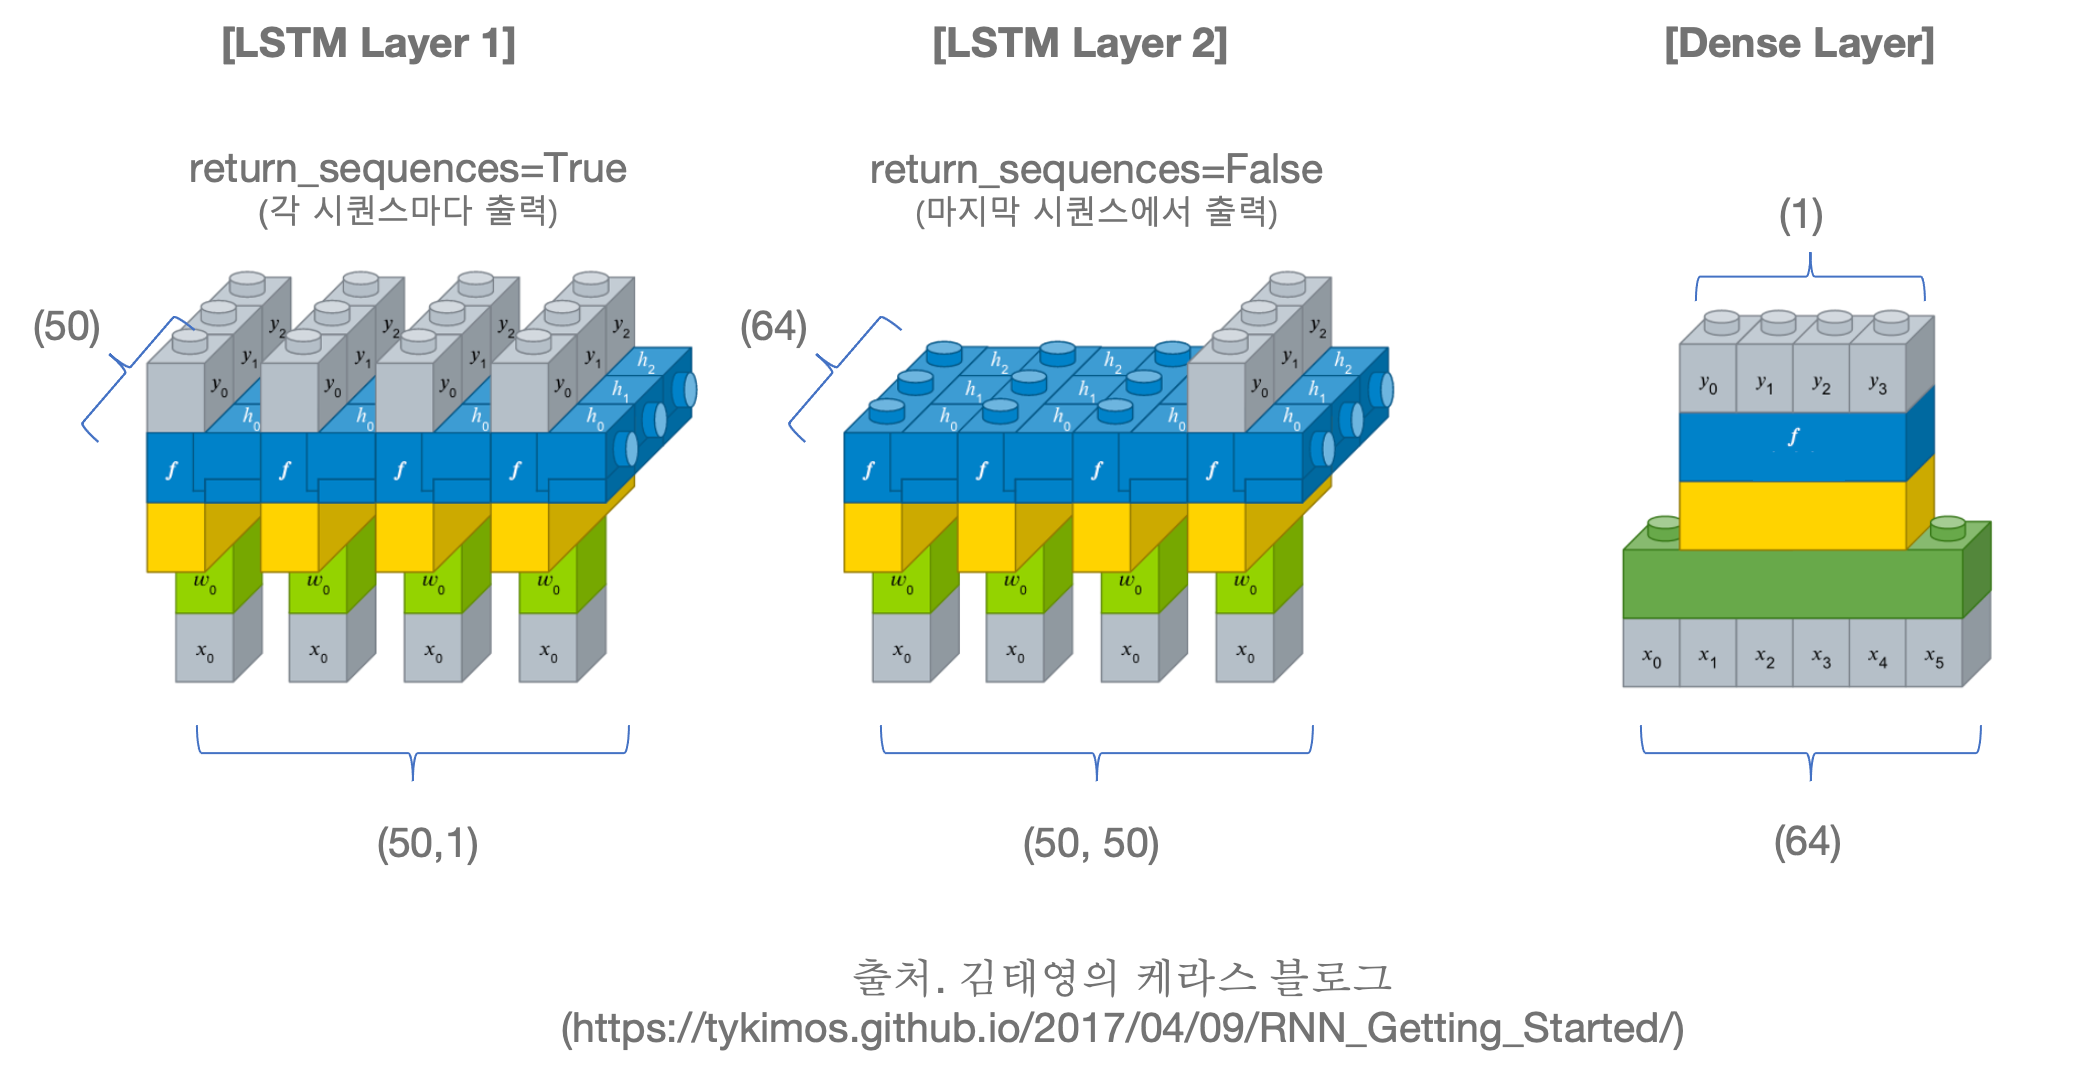

In [9]:
## LSTM params setting
input_size = x_train.size(2)   # 1(mid_price 변수 1개)
num_layers = 2
hidden_size = 64

#### keras(tensorflow)와 비교
```python
# keras sequential ver.
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
```

In [10]:
## pytorch LSTM model
class StockSamsung(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_length, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
#         print(out.size())  ## batch_size(10), sequence_length(50), hidden_size(64)
        out = out.reshape(out.shape[0], -1)  # batch외에 모두 feature로 변환 (10, 50*64)
        out = self.fc(out) ## (10, 50*64) -> (10, 1)
        return out

In [11]:
model = StockSamsung(
    input_size=input_size,
    hidden_size=hidden_size,
    sequence_length=seq_len,
    num_layers=num_layers,
    device=device).to(device)

lr = 1e-3
num_epochs = 20
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=lr)

In [12]:
model

StockSamsung(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=3200, out_features=1, bias=True)
)

# Training

In [13]:
## forward test. - 테스트용. 불필요
aa_x, aa_y = next(iter(train_loader))
print(aa_x.shape)   # torch.Size([10, 50, 1])
predict_y = model(aa_x)
predict_y.size(), predict_y

torch.Size([10, 50, 1])


(torch.Size([10, 1]),
 tensor([[-0.0033],
         [-0.0037],
         [-0.0040],
         [-0.0036],
         [-0.0035],
         [-0.0034],
         [-0.0039],
         [-0.0038],
         [-0.0037],
         [-0.0035]], grad_fn=<AddmmBackward0>))

#### keras와 비교
```python
# keras ver.
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)
```

In [14]:
mean_epoch_loss_history = []
total_steps = len(train_loader)
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    mean_epoch_loss_history.append(epoch_loss/total_steps)
    print(f'epoch num {epoch} loss: {epoch_loss/total_steps}')

epoch num 0 loss: 0.04179414527771889
epoch num 1 loss: 0.002561638384886121
epoch num 2 loss: 0.0020419186234302855
epoch num 3 loss: 0.0020439332756894764
epoch num 4 loss: 0.0017062765513195322
epoch num 5 loss: 0.0013584449002079946
epoch num 6 loss: 0.0011284899349980064
epoch num 7 loss: 0.000982391439874674
epoch num 8 loss: 0.0008749483959894311
epoch num 9 loss: 0.0007794200258635925
epoch num 10 loss: 0.0006875735855159428
epoch num 11 loss: 0.001624509704959324
epoch num 12 loss: 0.0005052989339983126
epoch num 13 loss: 0.000492306401044842
epoch num 14 loss: 0.0004664716858692458
epoch num 15 loss: 0.0004238814113053212
epoch num 16 loss: 0.000380734735854104
epoch num 17 loss: 0.0015796917600624202
epoch num 18 loss: 0.0002738940774917247
epoch num 19 loss: 0.00027160629292237264


# Prediction

In [15]:
out_list = []
with torch.no_grad():
    for data in test_loader:
        seq, target = data
        out = model(seq)
        out = out.view(-1)
#         print(out.shape)
        out_list.extend(out.tolist())
out_list

[0.10608571767807007,
 0.11552505195140839,
 0.11886459589004517,
 0.11051006615161896,
 0.09370434284210205,
 0.06750215590000153,
 0.08440160751342773,
 0.08842529356479645,
 0.08281637728214264,
 0.06275878846645355,
 0.040710970759391785,
 0.018818331882357597,
 -0.001766081782989204,
 0.018578536808490753,
 0.015488510951399803,
 0.009900560602545738,
 0.02395758591592312,
 0.029617931693792343,
 -0.0013212509220466018,
 -0.006218305788934231,
 -0.006868212483823299,
 -0.001261805067770183,
 0.015126674436032772,
 0.029445510357618332,
 0.01763291284441948,
 0.027950633317232132,
 0.014676069840788841,
 -0.011410928331315517,
 -0.0091665955260396,
 -0.012705320492386818,
 -0.014830498956143856,
 -0.01483183167874813,
 -0.004284917842596769,
 -0.03317626938223839,
 -0.041564714163541794,
 -0.05164460092782974,
 -0.03226587176322937,
 -0.05207531899213791,
 -0.06500938534736633,
 -0.07058440893888474,
 -0.08875557035207748,
 -0.09690181910991669,
 -0.09751606732606888,
 -0.109776146

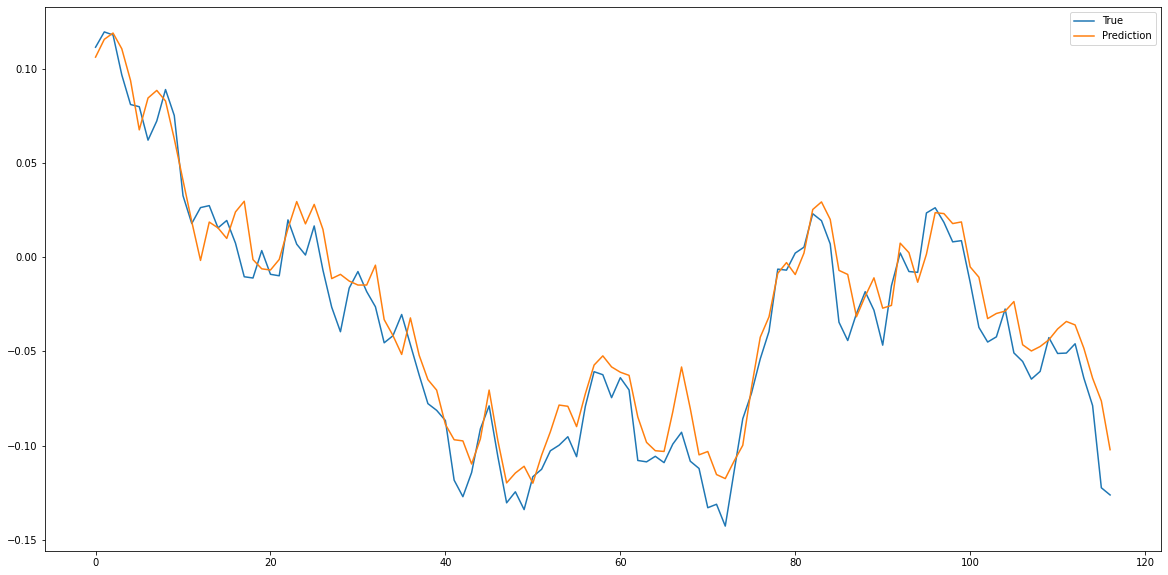

In [16]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(out_list, label='Prediction')
ax.legend()
plt.show()